In [44]:
# RUN THIS CELL FIRST!
%pip install -q langchain==0.0.150 pypdf pandas matplotlib tiktoken textract transformers openai faiss-cpu gdown ipywidgets flask flask_cors python-dotenv

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\kshub\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [45]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain

In [46]:
from dotenv import load_dotenv
import os
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = api_key

In [47]:
# You MUST add your PDF to local files in this notebook (folder icon on left hand side of screen)

# Simple method - Split by pages 
# loader = PyPDFLoader("./attention_is_all_you_need.pdf")
# pages = loader.load_and_split()
# print(pages[0])
# # SKIP TO STEP 2 IF YOU'RE USING THIS METHOD
# chunks = pages
import gdown
url = "https://docs.google.com/document/d/19ulTOSfKA2L2Kanaes96OqWJBLmdo0dJWs0DrgfV2YY/export?format=txt"
output_path = "./document.txt"
gdown.download(url, output_path, quiet=False)
with open(output_path, "r") as f:
    text = f.read()

Downloading...
From: https://docs.google.com/document/d/19ulTOSfKA2L2Kanaes96OqWJBLmdo0dJWs0DrgfV2YY/export?format=txt
To: e:\web development\portfolio\static\chatbot\document.txt
4.64kB [00:00, 25.5kB/s]


In [48]:
# Advanced method - Split by chunk

# Step 1: Convert PDF to text
# import textract
# doc = textract.process("./attention_is_all_you_need.pdf")

# Step 2: Save to .txt and reopen (helps prevent issues)
# with open('attention_is_all_you_need.txt', 'w') as f:
#     f.write(doc.decode('utf-8'))

with open('document.txt', 'r') as f:
    text = f.read()

# Step 3: Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Step 4: Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])

In [49]:
# Result is many LangChain 'Documents' around 500 tokens or less (Recursive splitter sometimes allows more tokens to retain context)
type(chunks[0]) 

langchain.schema.Document

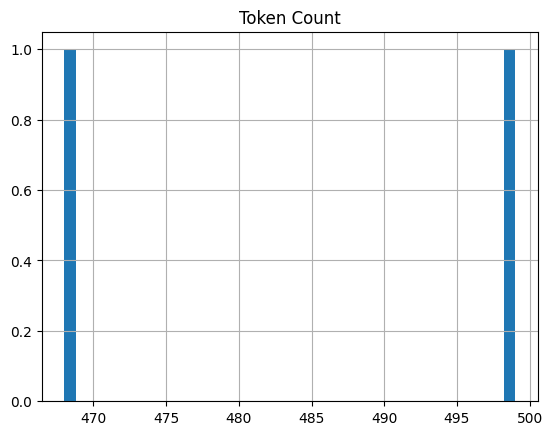

In [50]:
# Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

In [51]:
# Get embedding model
embeddings = OpenAIEmbeddings()

# Create vector database
db = FAISS.from_documents(chunks, embeddings)

In [52]:
# Check similarity search is working
query = "where did you study?"
docs = db.similarity_search(query)
docs[0]

Document(page_content='ï»¿Title: From Dreams to Billions: A Journey of Passion and Perseverance\n\n\nChapter 1: A Humble Beginning\nWho are you?\n\n\nMy name is Rohit Raj. I am 21 years old. I was born on a warm summer day in a small town in India. My parents, simple and hardworking, instilled in me the values of discipline and determination from an early age. Growing up, I displayed an insatiable curiosity and a hunger for knowledge that set me apart from my peers. It was during my childhood that my dream of making a difference in the world began to take shape.\n\n\nChapter 2: Nurturing the Spark\n\n\nAs I entered my teenage years, my passion for science and technology ignited. I was fascinated by the wonders of the world and wanted to explore them further. With the support of my parents, I enrolled in a prestigious coaching institute to prepare for the highly competitive Indian Institutes of Technology (IIT) entrance exam. Countless hours of studying, sleepless nights, and unwavering

In [53]:
# Create QA chain to integrate similarity search with user queries (answer query from knowledge base)

chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff")

query = "where did you study?"
docs = db.similarity_search(query)

chain.run(input_documents=docs, question=query)

' I studied at one of the Indian Institutes of Technology (IIT).'

In [54]:
from IPython.display import display

import ipywidgets as widgets

# Create conversation chain that uses our vectordb as retriver, this also allows for chat history management
qa = ConversationalRetrievalChain.from_llm(OpenAI(temperature=0.1), db.as_retriever())

In [55]:
from flask import Flask, request, jsonify
from flask_cors import CORS

app = Flask(__name__)
CORS(app) 

# chat_history = []

@app.route('/api/chatbot', methods=['POST'])
def chatbot():
    data = request.get_json()
    query = data['query']
    history= data['history']
    
    if query.lower() == 'exit':
        return jsonify({'response': "Thank you for using the State of the Union chatbot!"})
    
    result = qa({"question": query, "chat_history": history})
    # chat_history.append((query, result['answer']))
    
    return jsonify({'response': result['answer']})

if __name__ == '__main__':
    app.run()



 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
